In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.impute import KNNImputer
import plotly.express as ex
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score

In [151]:
pd.set_option('display.max_columns', 30)
data  = pd.read_csv(r'D:\Users\91917\Downloads\Chennai houseing sale.csv')

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRT_ID         7109 non-null   object 
 1   AREA           7109 non-null   object 
 2   INT_SQFT       7109 non-null   int64  
 3   DATE_SALE      7109 non-null   object 
 4   DIST_MAINROAD  7109 non-null   int64  
 5   N_BEDROOM      7108 non-null   float64
 6   N_BATHROOM     7104 non-null   float64
 7   N_ROOM         7109 non-null   int64  
 8   SALE_COND      7109 non-null   object 
 9   PARK_FACIL     7109 non-null   object 
 10  DATE_BUILD     7109 non-null   object 
 11  BUILDTYPE      7109 non-null   object 
 12  UTILITY_AVAIL  7109 non-null   object 
 13  STREET         7109 non-null   object 
 14  MZZONE         7109 non-null   object 
 15  QS_ROOMS       7109 non-null   float64
 16  QS_BATHROOM    7109 non-null   float64
 17  QS_BEDROOM     7109 non-null   float64
 18  QS_OVERA

In [153]:
# sales price has high corr with reg_fee, Int_sqrt , and number of rooms
pric = data.corr().stack().reset_index().sort_values(by=0, ascending =False)
pric[pric.level_0 == 'SALES_PRICE']

level_0        level_1         0
143  SALES_PRICE    SALES_PRICE  1.000000
141  SALES_PRICE        REG_FEE  0.878148
142  SALES_PRICE         COMMIS  0.626275
132  SALES_PRICE       INT_SQFT  0.612125
136  SALES_PRICE         N_ROOM  0.602760
134  SALES_PRICE      N_BEDROOM  0.330999
135  SALES_PRICE     N_BATHROOM  0.108884
137  SALES_PRICE       QS_ROOMS  0.021967
140  SALES_PRICE     QS_OVERALL  0.020556
139  SALES_PRICE     QS_BEDROOM  0.018804
133  SALES_PRICE  DIST_MAINROAD  0.018783
138  SALES_PRICE    QS_BATHROOM -0.011377

In [154]:
# dropping unnecessory columns
data = data.drop(columns = ['COMMIS', 'MZZONE', 'UTILITY_AVAIL', 'PRT_ID'])

In [155]:
data.DATE_BUILD = pd.to_datetime(data.DATE_BUILD)
data.DATE_SALE = pd.to_datetime(data.DATE_SALE)

<AxesSubplot:>

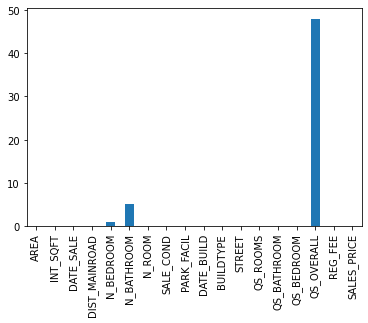

In [157]:
# OS_overall has higest null value folled by N_bathroom and N_bedroom
data.isna().sum().plot(kind ='bar')

In [9]:
#  filling null values
data.N_BATHROOM.fillna(data.N_BATHROOM.mean(), inplace=True)
data.N_BEDROOM.fillna(data.N_BEDROOM.mean(), inplace=True)

In [10]:
bad = data.AREA.value_counts()
bat = bad.index[bad  <= 3]
data.loc[data.AREA.isin(bat), 'AREA'] = 'other'

<AxesSubplot:>

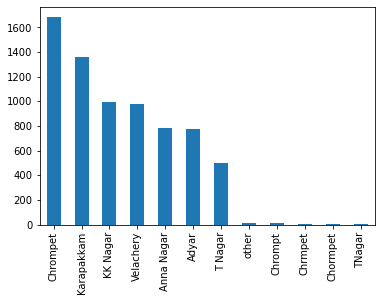

In [11]:
# area chrompet has high frequency 
.AREA.value_counts().plot(kind = 'bar')

In [12]:
data = data[(data.N_BEDROOM* 5 ) <=  data.INT_SQFT]

<AxesSubplot:xlabel='AREA'>

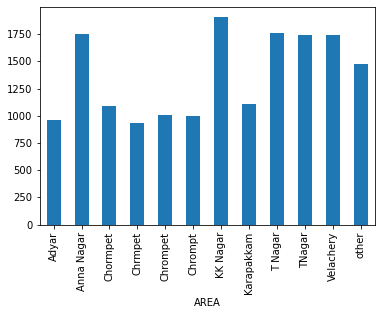

In [13]:
# KK nagar has big homes mean 1750 sqare feet homes

data.groupby('AREA')['INT_SQFT'].mean().plot(kind = 'bar')

In [14]:
ex.scatter(data_frame=data, x = data.N_ROOM, y =data.SALES_PRICE, color=data.N_BEDROOM)

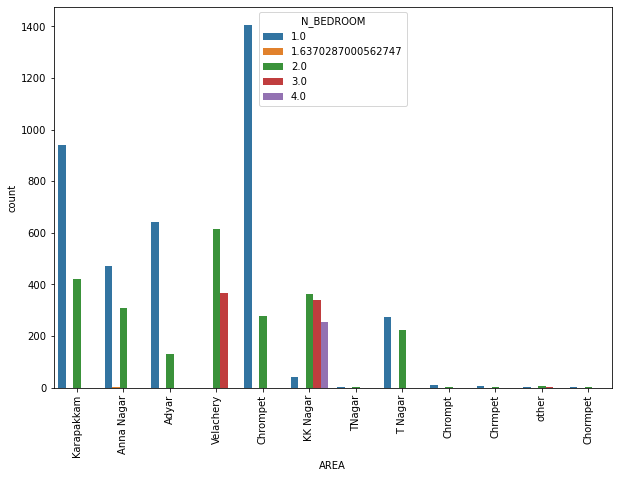

In [16]:
# only kk nagar has 4 bed-room rooms followed by velachery with 3 bed-rooms home
plt.figure(figsize =(10,7))
sns.countplot(x= data.AREA, hue = data.N_BEDROOM)
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:xlabel='SALE_COND', ylabel='count'>

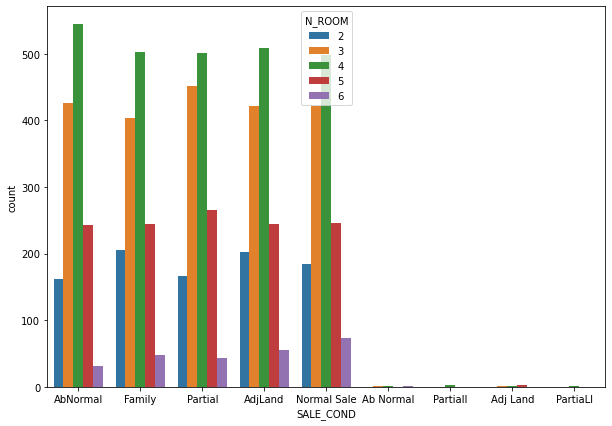

In [17]:
plt.figure(figsize =(10,7))
sns.countplot(x= data.SALE_COND, hue=data.N_ROOM)

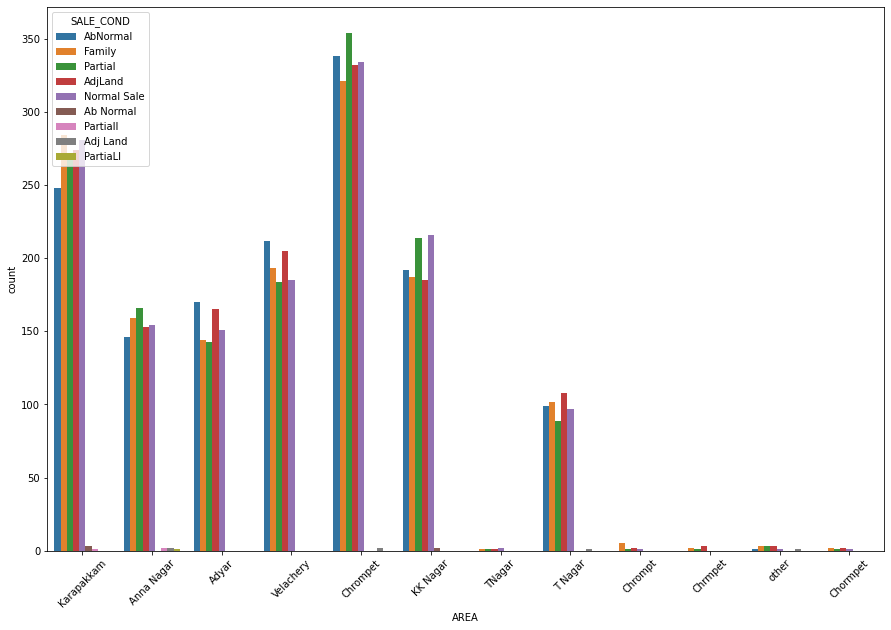

In [18]:
plt.figure(figsize =(15,10))
sns.countplot(x =data.AREA, hue = data.SALE_COND)
plt.xticks(rotation = 45)
plt.show()

In [22]:
# Velachery area has one of oldest homes
data[['AREA', 'DATE_BUILD']].sort_values(by = 'DATE_BUILD').head()

AREA DATE_BUILD
3848  Velachery 1949-10-28
1358  Velachery 1949-12-19
3050  Velachery 1950-01-29
3126  Velachery 1950-08-17
3100  Velachery 1951-03-06

In [23]:
data.BUILDTYPE.replace({'Comercial':'Commercial', 'Other': 'Others'}, inplace = True)
data.SALE_COND.replace({'Ab Normal': 'AbNormal', 'Adj Land':'AdjLand', 'PartiaLl': 'Partial', 'Partiall':'Partial'}, inplace =True)
data.AREA.replace({'Chrompt': "Chrompet", "Chrmpet":'Chrompet', 'TNagar':'T Nagar'}, inplace =True )
data.PARK_FACIL.replace({'Noo': 'No'}, inplace =True )
data.STREET.replace({'NoAccess':'No Access', 'Pavd':'Paved'}, inplace =True)


<AxesSubplot:xlabel='SALE_COND'>

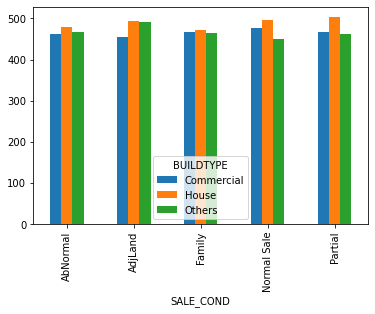

In [24]:

pd.crosstab(data.SALE_COND, data.BUILDTYPE).plot(kind = 'bar')

In [26]:
# number of house, commercial, and other in each area
data.groupby('AREA')['BUILDTYPE'].value_counts()

AREA        BUILDTYPE 
Adyar       Others        264
            House         262
            Commercial    247
Anna Nagar  House         275
            Others        258
            Commercial    250
Chormpet    Others          4
            House           2
Chrompet    House         589
            Commercial    562
            Others        545
KK Nagar    House         348
            Others        327
            Commercial    321
Karapakkam  House         485
            Others        447
            Commercial    431
T Nagar     Commercial    178
            Others        167
            House         156
Velachery   Commercial    334
            House         323
            Others        322
other       Commercial      6
            House           4
            Others          2
Name: BUILDTYPE, dtype: int64

In [27]:
a = pd.crosstab(data.AREA, data.BUILDTYPE, margins = True)

In [28]:
a['house_pro'] = a.House/a.All
a['commer_pro'] = a.Commercial/a.All
a['Other_pro'] = a.Others/a.All

<AxesSubplot:xlabel='AREA'>

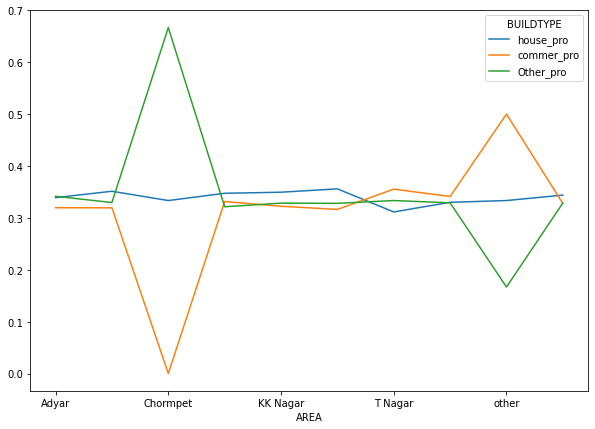

In [29]:
# area for house- all good but karapakkam and anna nagar has higher propotion of house
# for commerial room others has high proportion but T-Nagar also showing good figure
a[['house_pro', 'commer_pro', 'Other_pro']].plot(kind = 'line', figsize=(10,7))

In [30]:
data['meter'] =pd.cut(data.DIST_MAINROAD, 4, labels=['50 meter', '100 meter', '150 meter', '200 meter'])

<AxesSubplot:xlabel='BUILDTYPE', ylabel='count'>

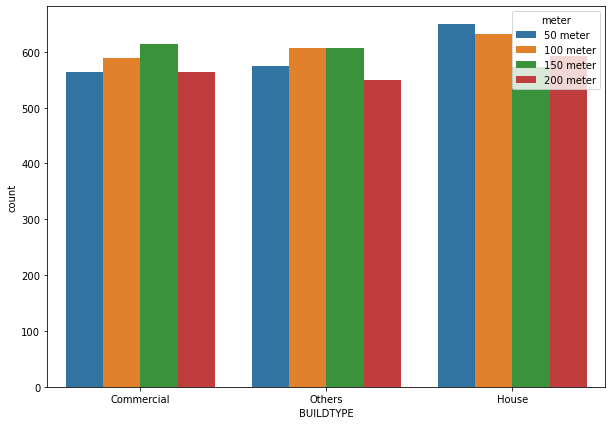

In [31]:
# houses has many values for 50 meter away, mean many house is loacated nearby the main streat
plt.figure(figsize = (10,7))
sns.countplot(x=data.BUILDTYPE, hue = data.meter)

array([<AxesSubplot:ylabel='50 meter'>, <AxesSubplot:ylabel='100 meter'>,
       <AxesSubplot:ylabel='150 meter'>, <AxesSubplot:ylabel='200 meter'>],
      dtype=object)

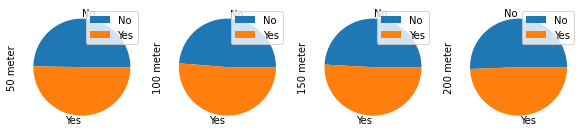

In [32]:
# parking is subtly tilted towords 100 m range rest has no effect distance of road
pd.crosstab(data.PARK_FACIL, data.meter).plot(kind = 'pie', subplots=True, figsize=(10,7))

array([<AxesSubplot:ylabel='50 meter'>, <AxesSubplot:ylabel='100 meter'>,
       <AxesSubplot:ylabel='150 meter'>, <AxesSubplot:ylabel='200 meter'>],
      dtype=object)

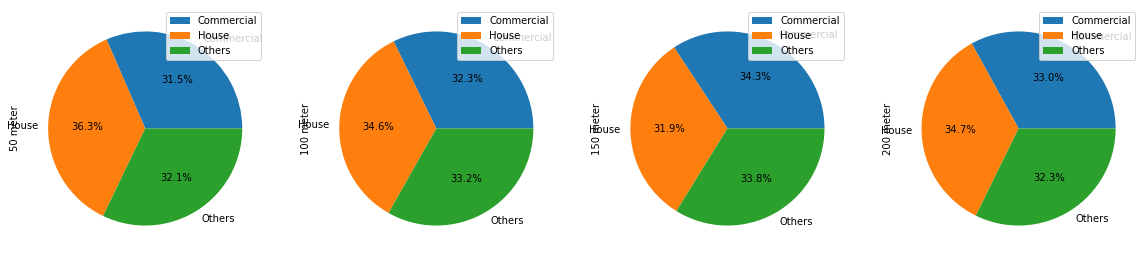

In [33]:
# houses are generally closer to main street 
pd.crosstab(data.BUILDTYPE, data.meter).plot(kind = 'pie', subplots=True,  figsize=(20,10), autopct = "%1.1f%%")

<AxesSubplot:xlabel='AREA', ylabel='count'>

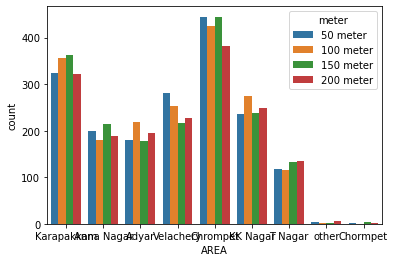

In [34]:
sns.countplot(x= data.AREA,  hue=data.meter)

<AxesSubplot:xlabel='BUILDTYPE', ylabel='AREA'>

<Figure size 1440x504 with 0 Axes>

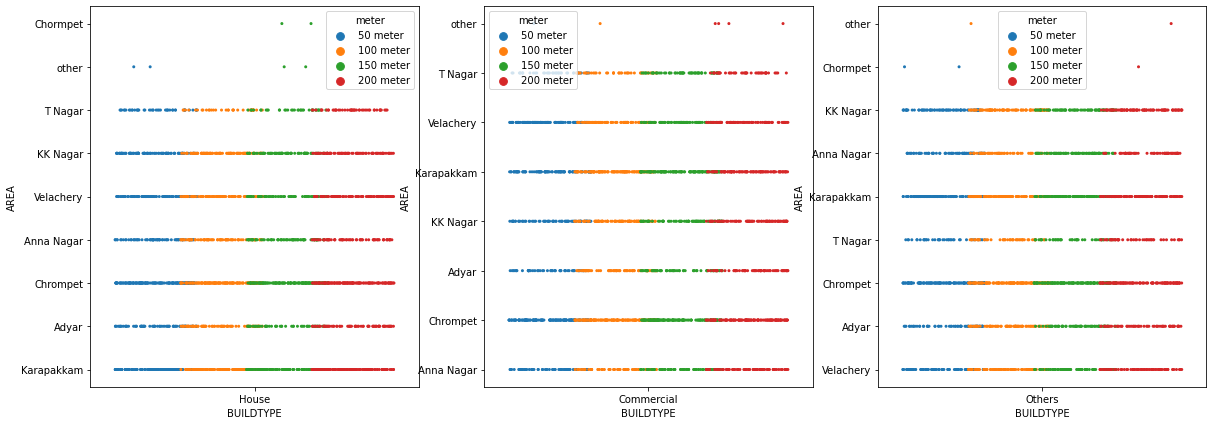

In [35]:
# in house type chrompet, velachery,and karapakkam has high density of 50 meter away streat 
# commercial buildtype is mostly have 200 meter away from streat 
plt.figure(figsize = (20,7))
fig, (ax,ax1,ax3) = plt.subplots(1,3, figsize = (20,7))

sns.stripplot(y =data.AREA, x = data.BUILDTYPE[data.BUILDTYPE=='House'], hue=data.meter, jitter=0.5,dodge= True, orient= "v", size=3, ax =ax) 
sns.stripplot(y =data.AREA, x = data.BUILDTYPE[data.BUILDTYPE=='Commercial'], hue=data.meter, jitter=0.5,dodge= True, orient= "v", size=3, ax =ax1)
sns.stripplot(y =data.AREA, x = data.BUILDTYPE[data.BUILDTYPE=='Others'], hue=data.meter, jitter=0.5,dodge= True, orient= "v", size=3, ax =ax3)

<AxesSubplot:xlabel='AREA', ylabel='count'>

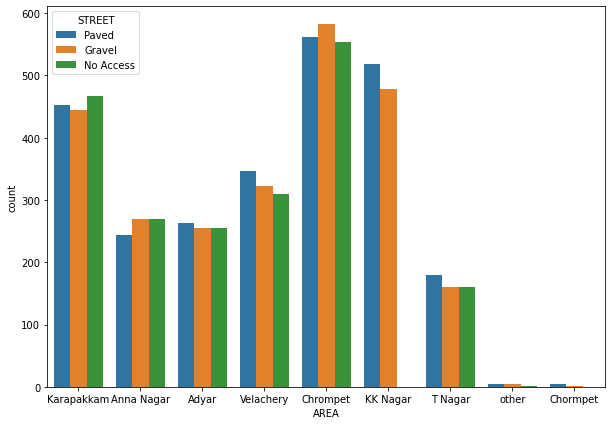

In [36]:
plt.figure(figsize = (10,7))
sns.countplot(data.AREA, hue = data.STREET)


<AxesSubplot:ylabel='QS_OVERALL'>

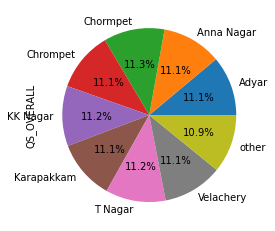

In [40]:
# all colonies got about same % of ratings 
data.groupby('AREA')['QS_OVERALL'].mean().plot(kind  = 'pie' , autopct = '%1.1f%%')

In [41]:
data.REG_FEE.describe()

count      7109.000000
mean     376938.330708
std      143070.662010
min       71177.000000
25%      272406.000000
50%      349486.000000
75%      451562.000000
max      983922.000000
Name: REG_FEE, dtype: float64

<AxesSubplot:xlabel='INT_SQFT', ylabel='REG_FEE'>

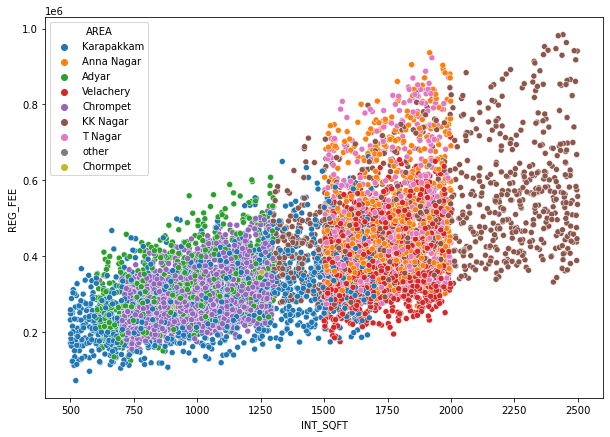

In [42]:
# Kk nagar has max sqare feet home and their registration fee is also high
plt.figure(figsize = (10,7))
sns.scatterplot(data.INT_SQFT, data.REG_FEE, hue=data.AREA)

<AxesSubplot:xlabel='INT_SQFT', ylabel='SALES_PRICE'>

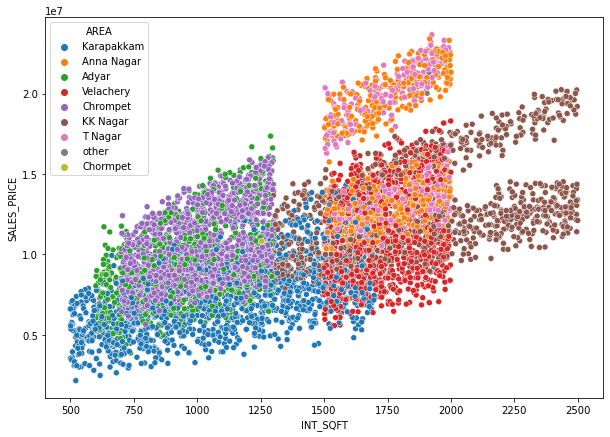

In [43]:
# as expected postive corr between price and square feet land 
plt.figure(figsize = (10,7))
sns.scatterplot( data.INT_SQFT,data.SALES_PRICE, hue=data.AREA)

In [44]:
data['DATE_BUILD'] = data.DATE_BUILD.dt.year
data['DATE_SALE'] = data.DATE_SALE.dt.year
# column =stand sca 1, 3, 4, 5, 6,12, 13, 14, 15, 16, 2, 9
# ordinal = 0, 7, 8, 10,11,18
# kkfille= 15

In [45]:
# data = data.drop(columns='Date_BUILD')


## model building for prediciton 

In [58]:
data.dropna(inplace = True)
x = data.drop(columns = ['SALES_PRICE'])
y = data['SALES_PRICE']
xtn,xt, ytn, yt = train_test_split(x, y , test_size=0.3)

### using column transformer for transform columns

In [59]:
colT = ColumnTransformer([('col1', StandardScaler(), [1,2, 3, 4, 5, 6,9, 12, 13, 14, 15, 16]), ('col2', OneHotEncoder(), [0, 7, 8, 10,11]), ('col3', OrdinalEncoder(), [17])],remainder='passthrough')

In [66]:
X = colT.fit_transform(xtn)
test = colT.transform(xt)

In [67]:
Ran = RandomForestRegressor()
Ran.fit(X, ytn)

RandomForestRegressor()

In [68]:
Ran.score(X,ytn)

0.9944713252940914

In [158]:
pre = Ran.predict(test)
r2_score(yt, pre)  # R2 score come out to 96.1 %

0.9615000396324791

In [78]:
cross_val_score(Ran, test, yt, cv = 10).mean()

0.9537076386190512

<AxesSubplot:>

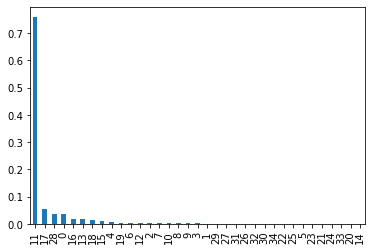

In [99]:
# 11th column after transformation has contain high information for 
pd.Series(Ran.feature_importances_).sort_values(ascending =False).plot(kind = 'bar')

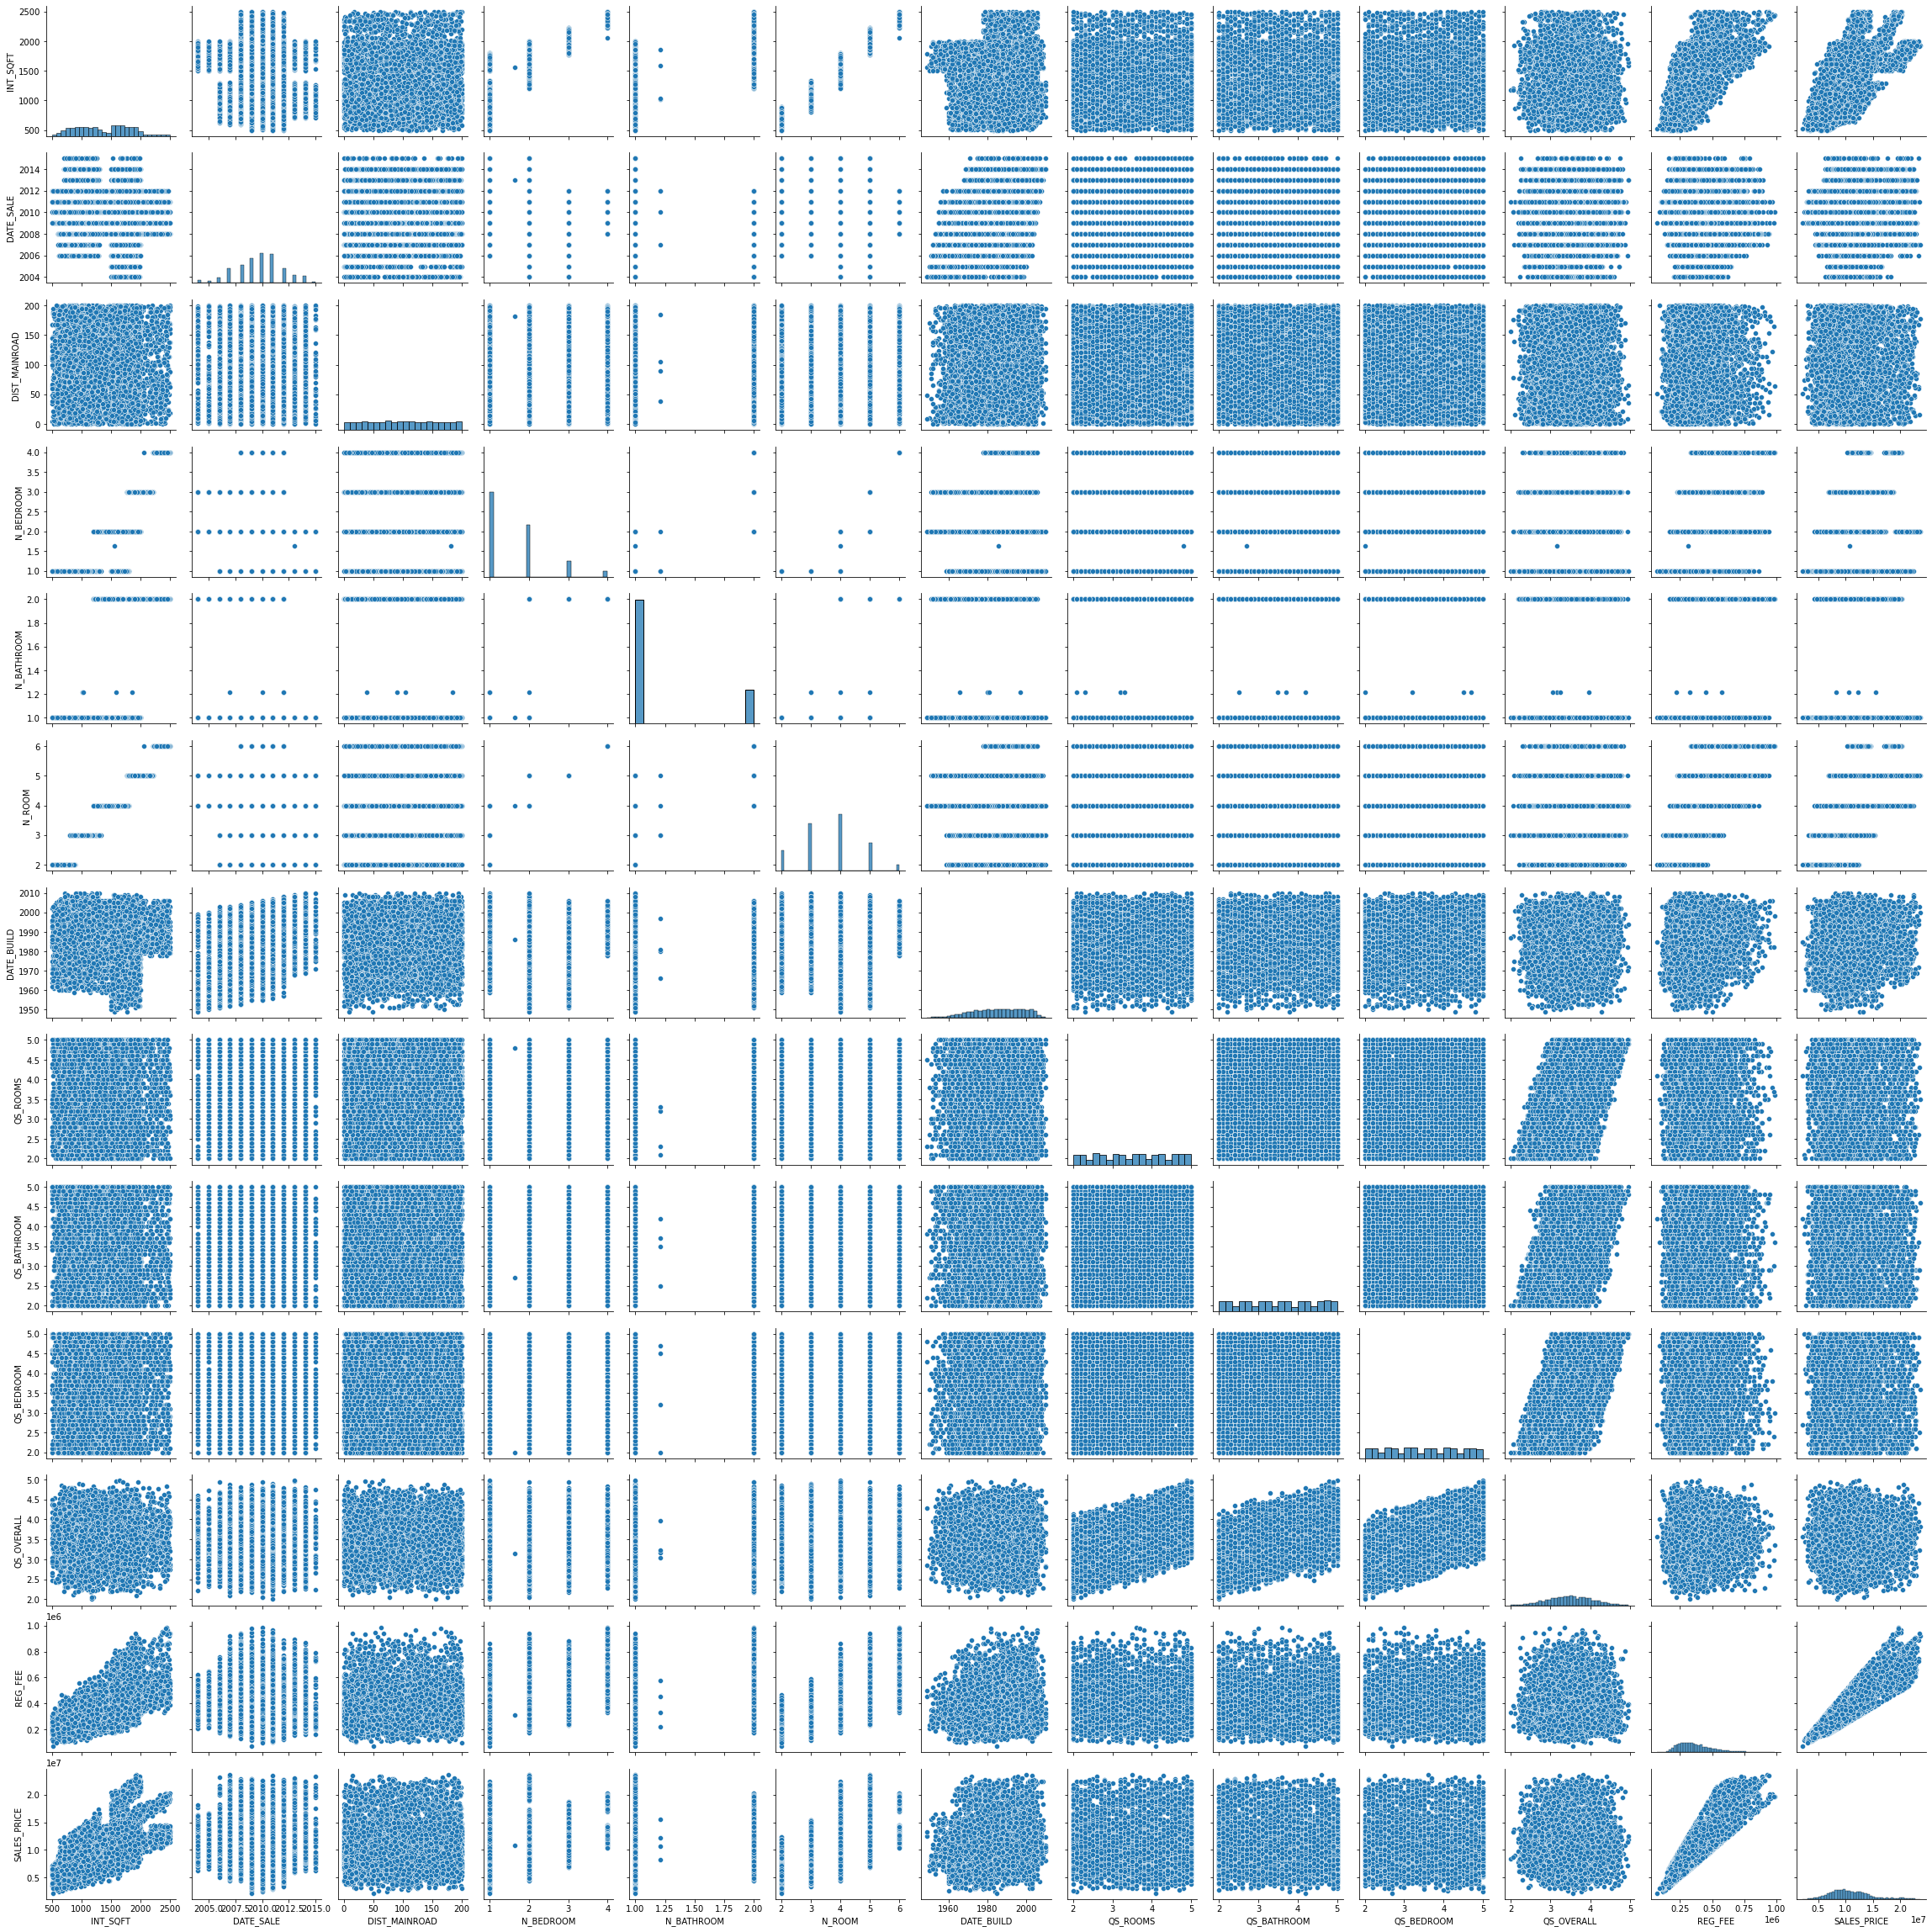

In [98]:
sns.pairplot(data)

In [109]:
# a random value for prediction 
ped = colT.transform(np.array(['Anna Nagar', 1900, 2000, 20, 2.0, 1.0,5, 'AbNormal', 'No', 1990,'Commercial','Gravel', 5, 4, 2, 3.2, 700000,'50 meter' ]).reshape(1,18))

In [110]:
Ran.predict(ped)

array([21026281.])

In [121]:
vottin= VotingRegressor([('f', SVR()), ('s', Ridge()), ('t', DecisionTreeRegressor()), ('fo', LinearRegression())], verbose=1)

In [122]:
vottin.fit(X, ytn)

[Voting] ........................ (1 of 4) Processing f, total=   1.4s
[Voting] ........................ (2 of 4) Processing s, total=   0.0s
[Voting] ........................ (3 of 4) Processing t, total=   0.0s
[Voting] ....................... (4 of 4) Processing fo, total=   0.1s


VotingRegressor(estimators=[('f', SVR()), ('s', Ridge()),
                            ('t', DecisionTreeRegressor()),
                            ('fo', LinearRegression())],
                verbose=1)

In [123]:
vottin.score(X, ytn)

0.9085846921799993

In [124]:
pre_y = vottin.predict(test)

In [125]:
cross_val_score(vottin,test, yt, cv=10 ).mean()

[Voting] ........................ (1 of 4) Processing f, total=   0.3s
[Voting] ........................ (2 of 4) Processing s, total=   0.0s
[Voting] ........................ (3 of 4) Processing t, total=   0.0s
[Voting] ....................... (4 of 4) Processing fo, total=   0.0s
[Voting] ........................ (1 of 4) Processing f, total=   0.2s
[Voting] ........................ (2 of 4) Processing s, total=   0.0s
[Voting] ........................ (3 of 4) Processing t, total=   0.0s
[Voting] ....................... (4 of 4) Processing fo, total=   0.0s
[Voting] ........................ (1 of 4) Processing f, total=   0.2s
[Voting] ........................ (2 of 4) Processing s, total=   0.0s
[Voting] ........................ (3 of 4) Processing t, total=   0.0s
[Voting] ....................... (4 of 4) Processing fo, total=   0.0s
[Voting] ........................ (1 of 4) Processing f, total=   0.2s
[Voting] ........................ (2 of 4) Processing s, total=   0.0s
[Votin

0.8877709582559083

In [137]:
from sklearn.metrics import r2_score
r2_score(yt, pre_y)

0.8920983041115352